In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import dask
import geopandas as gpd
import rasterio as rio
import datetime as dt
import requests
import pandas as pd

### Load and prepare spicy snow depth data

In [2]:
# open spicy dataset as xarray dataset
dask.config.set({"array.slicing.split_large_chunks": False})
ds = xr.open_mfdataset(glob.glob('/home/jovyan/spicy-snow/er_test/*.nc'))

In [3]:
# select snow depth and reproject to utm 
sd_da = ds.snow_depth.transpose('time', 'y', 'x')
crs = sd_da.rio.estimate_utm_crs()
sd_da = sd_da.rio.reproject(crs)

In [4]:
# open aoi geojson as geopandas dataframe and reproject
aoi_fn = '/home/jovyan/spicy-snow/east_river_basin_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

In [5]:
# clip to aoi, clip to reference areas
sd_da = sd_da.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

### Load SNOTEL data

In [6]:
def get_awdb_data(
    site_ids,
    server,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=dt.datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}/{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

In [7]:
def grab_snotel(aoi_gdf, buffer=1000):
    '''
    Takes a geodataframe containing an area of interest and returns SNOTEL data from 
    stations within some distance of that area of interest. Geodataframe assumed to 
    be projected in appropriate utm zone. 
    '''
    # get SNTL data using an API built by Beau Uriona
    AWDB_API_DOMAIN = "https://api.snowdata.info"

    # pull in metadata for all NRCS SNOTEL sites
    sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"
    sntl_gdf = gpd.read_file(sntl_meta_url).to_crs(aoi_gdf.crs)

    # find sites within some distance of aoi
    aoi_gdf['geometry'] = aoi_gdf.buffer(buffer)
    sntl_gdf = gpd.overlay(sntl_gdf, aoi_gdf, how='intersection')
    
    # build dict with station names and ids
    site_ids = list(sntl_gdf.stationTriplet)
    
    # download snotel data
    sntl_dfs = get_awdb_data(site_ids, server=AWDB_API_DOMAIN)
    
    # Make the index a datetime
    for i,df in enumerate(sntl_dfs):
        df.index = pd.to_datetime(df.index)
        sntl_dfs[i] = df

    # create a dictionary for conversion to xarray
    sntl_df_dict = {
        site_ids[0]:pd.concat(sntl_dfs[0:3], axis=1).sort_index().to_xarray(),
        site_ids[1]:pd.concat(sntl_dfs[3:6], axis=1).sort_index().to_xarray()
        }
    
    # convert to xarray
    sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
    
    return sntl_ds

In [8]:
sntl_ds = grab_snotel(aoi_gdf)

getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-09
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-09
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-09
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-09
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-09
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-09


In [9]:
sntl_ds['SNWD'] = sntl_ds['SNWD']*0.0254

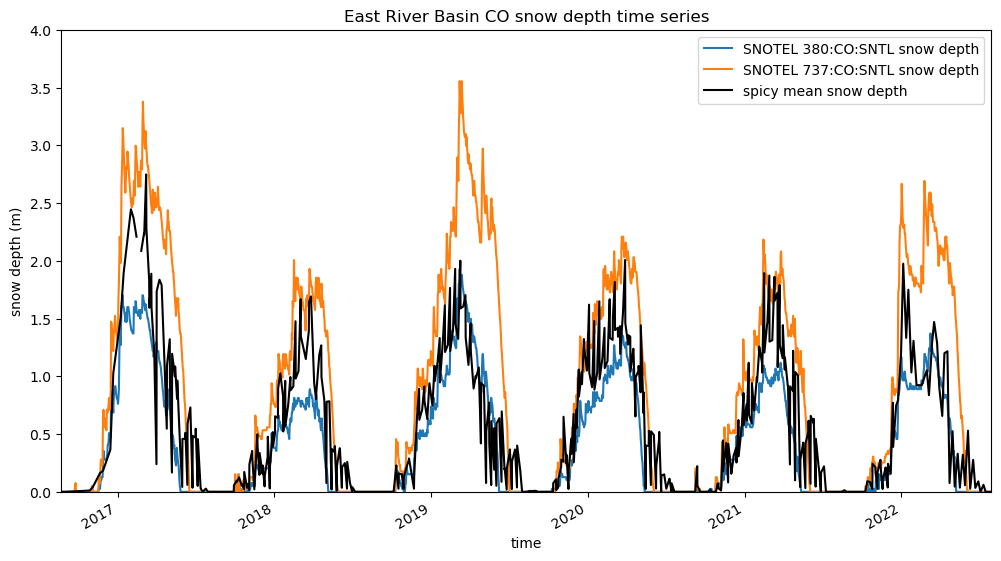

In [10]:
# plot snow depth time series
f, ax = plt.subplots(figsize=(12, 6))
for site in sntl_ds.Location:
    sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
sd_da.mean(dim=['x', 'y']).plot(c='k', label='spicy mean snow depth')
ax.set_xlim(sd_da.time[0], sd_da.time[-1])
ax.set_ylim(0, 4)
ax.set_ylabel('snow depth (m)')
ax.legend()
ax.set_title('East River Basin CO snow depth time series')

plt.savefig('east_river_ts.png', dpi=300)

In [42]:
np.nan > -1

False

In [55]:
sd_da.quantile(q=0.1, dim=['x', 'y']).dropna(dim='time')

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<xarray.DataArray 'snow_depth' (time: 598)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.97982382e-01, 5.60909842e-01, 4.36305885e-01,
       3.49304105e-01, 2.92360625e-01, 4.32504303e-01, 3.18750821e-01,
       4.43456994e-01, 1.77540715e-01, 6.20238740e-01, 1.23650531e-01,
       0.00000000e+00, 0.00000000e+00, 4.22256257e-02, 0.00000000e+00,
       0.00000000e+00, 1.87747566e-01, 4.27531378e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.05594065e-01,
       7.58898474e-01, 1.97231674e-01, 6.22288203e-01, 2.22015707e-02,
       3.79631833e-01, 0.00000000e+00, 0.00000000e+00, 1.57677656e-02,
       0.00000000e+00, 2.16769452e-01, 2.71036252e-01, 2.19055653e-01,
       0.00000000e+00, 0.00000000e+00, 1.69402328e-01, 9.06883982e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])
Coordinates:
  * time            (time) datetime64[ns] 2016-08-23T01:10:07 ... 2022-07-30T...
    platform        (time) object 'S1A' 'S1A' 'S1B' 'S1B' ... 'S1A' 'S1A' 'S1A'
    absolute_orbit  (time) float64 1.272e+04 1.282e+04 ... 4.43e+04 4.432e+04
    flight_dir      (time) object 'ascending' 'ascending' ... 'ascending'
    relative_orbit  (time) float64 49.0 151.0 49.0 151.0 ... 56.0 129.0 151.0
    quantile        float64 0.1

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


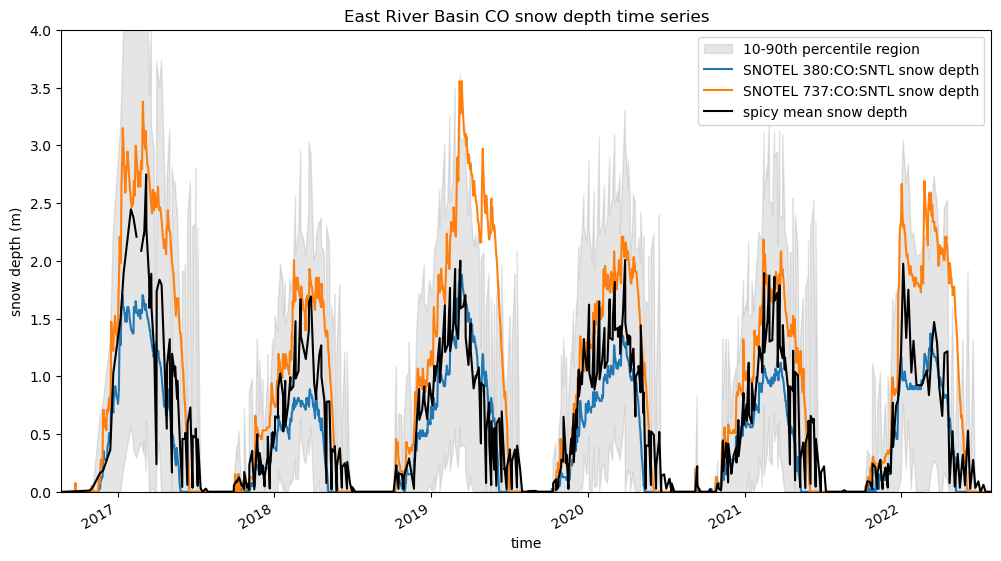

In [65]:
# plot snow depth time series
f, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(sd_da.quantile(q=0.1, dim=['x', 'y']).dropna(dim='time').time,
                sd_da.quantile(q=0.1, dim=['x', 'y']).dropna(dim='time').values,
                sd_da.quantile(q=0.9, dim=['x', 'y']).dropna('time').values,
                alpha=0.2, color='Grey', label='10-90th percentile region')
for site in sntl_ds.Location:
    sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
sd_da.mean(dim=['x', 'y']).plot(c='k', label='spicy mean snow depth')
ax.set_xlim(sd_da.time[0], sd_da.time[-1])
ax.set_ylim(0, 4)
ax.set_ylabel('snow depth (m)')
ax.legend()
ax.set_title('East River Basin CO snow depth time series')

plt.savefig('east_river_ts.png', dpi=300)

In [11]:
sntl_ds_overpass = sntl_ds.sel(Date=sd_da.time, method='nearest')

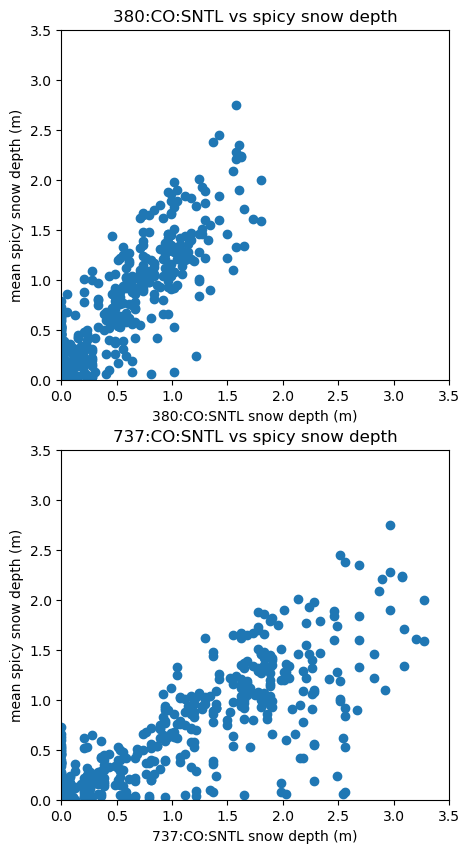

In [66]:
# plot spicy vs snotel snow depths
f, ax = plt.subplots(len(sntl_ds.Location), 1, figsize=(5, len(sntl_ds.Location)*5))
for i, site in enumerate(sntl_ds.Location):
    ax[i].scatter(sntl_ds_overpass.sel(Location=site).SNWD, sd_da.mean(dim=['x', 'y']))
    ax[i].set_xlim(0, 3.5)
    ax[i].set_ylim(0, 3.5)
    ax[i].set_title(f'{site.values} vs spicy snow depth')
    ax[i].set_xlabel(f'{site.values} snow depth (m)')
    ax[i].set_ylabel('mean spicy snow depth (m)')
    
plt.savefig('east_river_snotelvspicy.png', dpi=300)

### Load stream gauge data